# Imports and hyperparameters

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools


MAX_LENGTH = 200
VOCABULARY_SIZE = 10000
EMBEDDING_DIM = 32
seq_length = 500
BATCHSIZE = 32

# Data downloading and preprocessing
Setting the hyper parameters "VOCABULARY_SIZE", "EMBEDDING_DIM" and "seq_length", getting data from keras library (imdb.load_data method) and making them sequences (numerical values) of the same size (size of the vocabulary)

In [ ]:
def get_dataset(vocab_size):
  (x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=VOCABULARY_SIZE)
  return  x_train, y_train, x_val, y_val

x_train, y_train, x_test, y_test = get_dataset(VOCABULARY_SIZE)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
def preprocessing(x):
  x = tf.keras.preprocessing.sequence.pad_sequences(x,
                                                    maxlen=MAX_LENGTH,
                                                    padding='pre')
  return x

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)

# Model buiding
Building the model and visualizing it

In [ ]:
def build_conv_model(vocabulary_size, embedding_dim, input_length, summary=True):
  input_ = tf.keras.layers.Input(shape=(input_length), name='input')
  embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dim, name='embedding')(input_)

  branch_kernel_size3 = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                               activation='relu', name='conv1')(embedding)
  branch_kernel_size3 = tf.keras.layers.MaxPool1D(pool_size=2, name='pool1')(branch_kernel_size3)
  branch_kernel_size3 = tf.keras.layers.Dropout(0.5, name='drop1')(branch_kernel_size3)
  branch_kernel_size3 = tf.keras.layers.Flatten()(branch_kernel_size3)

  branch_kernel_size5 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                               activation='relu', name='conv2')(embedding)
  branch_kernel_size5 = tf.keras.layers.MaxPool1D(pool_size=2, name='pool2')(branch_kernel_size5)
  branch_kernel_size5 = tf.keras.layers.Dropout(0.5, name='drop2')(branch_kernel_size5)
  branch_kernel_size5 = tf.keras.layers.Flatten()(branch_kernel_size5)

  branch_kernel_size7 = tf.keras.layers.Conv1D(128, kernel_size=7, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                               activation='relu', name='conv3')(embedding)
  branch_kernel_size7 = tf.keras.layers.MaxPool1D(pool_size=2, name='pool3')(branch_kernel_size7)
  branch_kernel_size7 = tf.keras.layers.Dropout(0.5, name='drop3')(branch_kernel_size7)
  branch_kernel_size7 = tf.keras.layers.Flatten()(branch_kernel_size7)

  branch_kernel_size9 = tf.keras.layers.Conv1D(128, kernel_size=9, padding='same',
                                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                               activation='relu', name='conv4')(embedding)
  branch_kernel_size9 = tf.keras.layers.MaxPool1D(pool_size=2, name='pool4')(branch_kernel_size9)
  branch_kernel_size9 = tf.keras.layers.Dropout(0.5, name='drop4')(branch_kernel_size9)
  branch_kernel_size9 = tf.keras.layers.Flatten()(branch_kernel_size9)

  x = tf.keras.layers.concatenate([branch_kernel_size3, branch_kernel_size5,
                                   branch_kernel_size7, branch_kernel_size9],
                                  name='Concatenate')
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(inputs=[input_], outputs=[output], name='CNN_with_Combined_Kernels_from_multiple_branches')
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-2), metrics='accuracy')
  if summary:
    print(model.summary())
  
  return model

In [ ]:
def build_recurrent_model(vocabulary_size, embedding_dim, input_length, summary=True):
  input_ = tf.keras.layers.Input(shape=(input_length))
  x = tf.keras.layers.Embedding(vocabulary_size, embedding_dim, name='embedding')(input_)
  x = tf.keras.layers.GRU(256, name='gru', dropout=0.2)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(input_, output, name='GRU')
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-3), metrics='accuracy')
  if summary:
    print(model.summary())
  
  return model

In [ ]:
cnn_model = build_conv_model(VOCABULARY_SIZE, EMBEDDING_DIM, MAX_LENGTH)
gru_model = gru_model = build_recurrent_model(VOCABULARY_SIZE, EMBEDDING_DIM, MAX_LENGTH)

Model: "CNN_with_Combined_Kernels_from_multiple_branches"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 32)      320000      input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 200, 128)     12416       embedding[0][0]                  
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 200, 128)     20608       embedding[0][0]                  
___________________________________________________

# Training and evaluation

In [ ]:
def train_models(epochs):
  StopCbk = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)

  lrs = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1,
                                             patience=5,
                                             min_lr=1e-5)

  cnn_history = cnn_model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=BATCHSIZE, callbacks=[StopCbk, lrs])
  gru_history = gru_model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=BATCHSIZE, callbacks=[StopCbk, lrs])

  return cnn_history, gru_history

cnn_history, gru_history = train_models(30)

Epoch 1/30
625/625 [==============================] - 10s 10ms/step - loss: 0.5967 - accuracy: 0.7347 - val_loss: 0.3311 - val_accuracy: 0.8782
Epoch 2/30
625/625 [==============================] - 6s 9ms/step - loss: 0.2781 - accuracy: 0.9055 - val_loss: 0.3505 - val_accuracy: 0.8784
Epoch 3/30
625/625 [==============================] - 6s 9ms/step - loss: 0.2415 - accuracy: 0.9212 - val_loss: 0.3582 - val_accuracy: 0.8814
Epoch 4/30
625/625 [==============================] - 6s 9ms/step - loss: 0.2181 - accuracy: 0.9319 - val_loss: 0.4088 - val_accuracy: 0.8752
Epoch 5/30
625/625 [==============================] - 6s 9ms/step - loss: 0.2063 - accuracy: 0.9385 - val_loss: 0.4205 - val_accuracy: 0.8678
Epoch 6/30
625/625 [==============================] - 6s 9ms/step - loss: 0.1920 - accuracy: 0.9451 - val_loss: 0.4074 - val_accuracy: 0.8674
Epoch 7/30
625/625 [==============================] - 6s 9ms/step - loss: 0.1397 - accuracy: 0.9612 - val_loss: 0.4296 - val_accuracy: 0.8752
Epoc

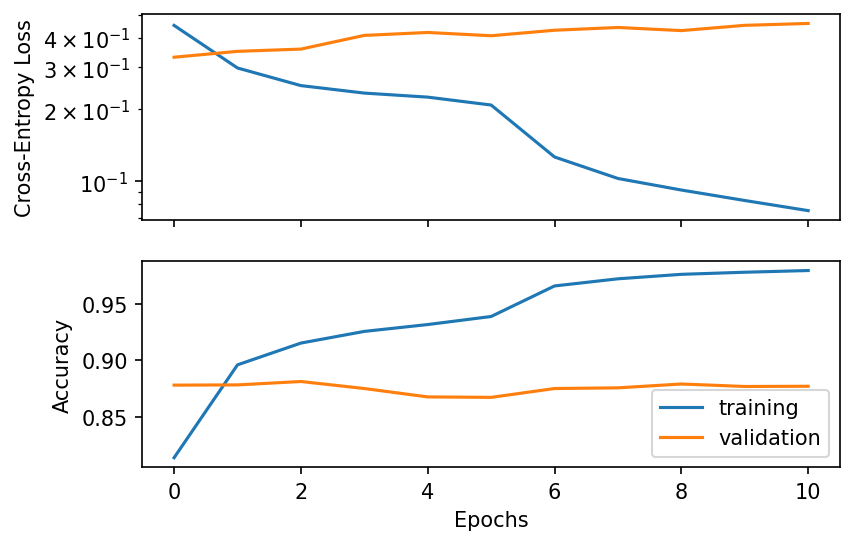

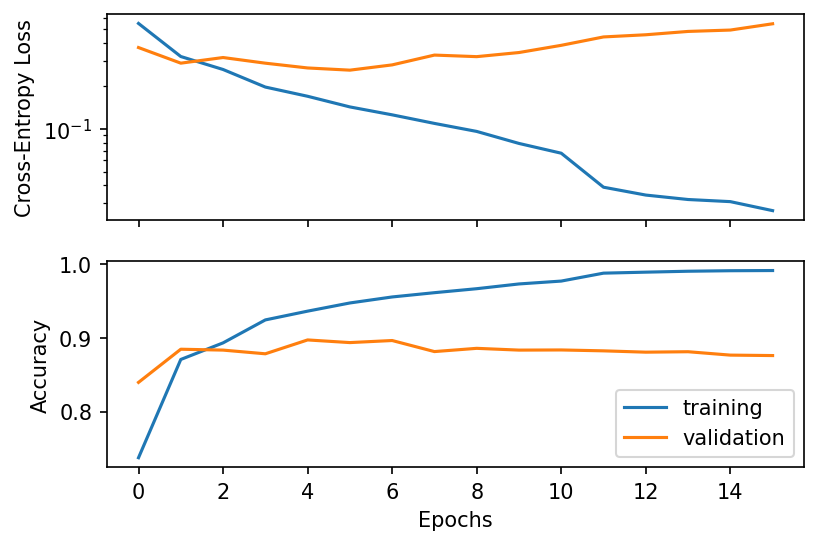

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show()

plot_history(cnn_history)
plot_history(gru_history)

In [ ]:
def ensemble_predictions(*models, **kwargs):
  if 'weights' not in kwargs:
    accuracys = [model.evaluate(x_test, y_test)[1] for model in models]
    weights = tf.convert_to_tensor(list(map(lambda x: x/sum(accuracys), accuracys)))
  else:
    assert len(models) == len(kwargs['weights']), 'numeber of weights should be the same as the number of models'
    weights = tf.convert_to_tensor(kwargs['weights'])
  x = tf.concat(values=([model.predict(x_test) for model in models]), axis=1)
  preds = tf.tensordot(x, weights, axes=1)
  return preds

predictions = ensemble_predictions(cnn_model, gru_model)
predictions_pre_weights = ensemble_predictions(cnn_model, gru_model, weights=[0.3, 0.7])

782/782 [==============================] - 4s 6ms/step - loss: 0.2719 - accuracy: 0.8888


In [ ]:
def evaluate_ensembling(predictions, targets):
  score = 0
  for pred, targ in zip(np.round(predictions), targets):
    score += int(pred) == int(targ)

  return score/targets.shape[0]

acc = evaluate_ensembling(predictions, y_test)
print(acc)

acc_pre_weights = evaluate_ensembling(predictions_pre_weights, y_test)
print(acc_pre_weights)

0.89264
0.89348


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[11197  1303]
 [ 1381 11119]]


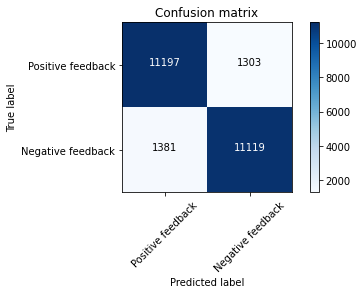

In [ ]:
cm = confusion_matrix(y_test, np.round(predictions))
plot_confusion_matrix(cm, ['Positive feedback', 'Negative feedback'])